# Model fitting. Determine Teff and log(g).

In [1]:
import sys
sys.path.append('/mnt/c/Users/luukv/Documenten/NatuurSterrkenkundeMasterProject/CodeMP/MasterProject')

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy.interpolate import CubicSpline
from PyAstronomy import pyasl
from scipy.optimize import curve_fit

from import_data import BailerJones
from model_functions import *
from functions import import_spectra, extract_spectrum_within_range

Import models and spectrum (~21 seconds)

In [2]:
# Import models for given galaxy
models = import_models('Milkyway')
# Import spectrum of given object
spectra = import_spectra('4U1538_52')

# Name of object
object_name = '4U1538-52'
# Distance to object
distance = BailerJones().loc[BailerJones().id == object_name]['r_med_photogeo'].reset_index(drop=True).at[0]

In [3]:
def select_spectrum(spectra: list, central_wav: float)->tuple:
    """
    Select the spectrum containing the given spectral line

    Args:
        spectra (list): List of spectra, made by import_spectra(object)
        central_wav (float): Central wavelenght of the spectral line

    Returns:
        tuple: wavelength, flux
    """
    for spectrum in spectra:
        if central_wav >= min(spectrum[0])  and central_wav <= max(spectrum[0]):
            return spectrum[0], spectrum[1]

In [4]:
filtered_models = models_in_interval(models, 30000, 35000, 3.0, 3.2)

### Perform $\chi^{2}$ fit for the $H\gamma$ (4340.26 $\AA$) for 4U1538-52
Crop the $H\gamma$ line

In [5]:
# Central wavelength of the line
line_wav = 4340.26 # Angstrom
# Range around the line
delta = 10
# Define a doppler shift
doppler = 2.3

Define the continuum and the spectral line

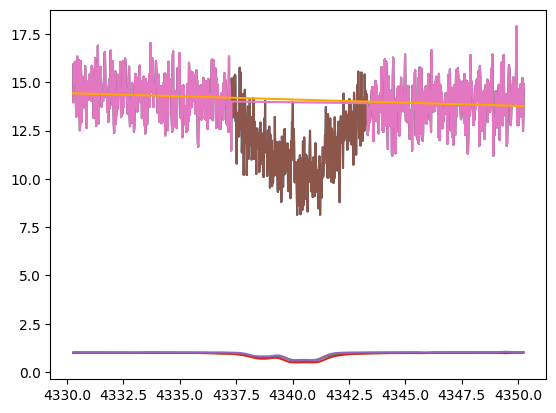

In [6]:
# Define the spectral line wavelenght range.
line_left = 4335 + doppler
line_right = 4341 + doppler

def extract_continuum(wavelengths: np.array, flux: np.array, start: float, end: float, line_left: float, line_right: float)->tuple:
    """
    Extract continuum from spectrum

    Args:
        wavelengths (np.array): List with wavelength
        flux (np.array): List with flux
        start (float): Start of spectrum
        end (float): End of spectrum
        line_left (float): Start spectral line
        line_right (float): End spectral line

    Returns:
        tuple: (Wavelength, Flux)
    """
    # Find indices corresponding to the specified wavelength range
    indices_left = np.where((wavelengths >= start) & (wavelengths <= line_left))[0]
    indices_right = np.where((wavelengths >= line_right) & (wavelengths <= end))[0]
    indices = np.concatenate((indices_left, indices_right))

    # Extract wavelength and flux values within the range
    extracted_wavelengths = wavelengths[indices]
    extracted_flux = flux[indices]

    return extracted_wavelengths, extracted_flux

# Get the spectrum (ADD A DOPPLERSHIFT)
wav = spectra[0][0] + doppler
flux = spectra[0][1]

# Get the continuum around the line
wav_cont, flux_cont = extract_continuum(wav, flux, line_wav-delta, line_wav+delta, line_left, line_right)
# Get the line
wav_line, flux_line = extract_spectrum_within_range(wav, flux, line_left, line_right)
# Get the whole range
wav_all, flux_all = extract_spectrum_within_range(wav, flux, line_wav-delta, line_wav+delta)

# Linear fit to continuum
p1 = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))

# Plot
plt.plot(wav_all, flux_all)
for model in filtered_models.values():
    wav, flux = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line_wav-delta, line_wav+delta)
    plt.plot(wav,flux)

plt.plot(wav_all, flux_all)
plt.plot(wav_cont, flux_cont)
plt.plot(wav_all, p1(wav_all), color='orange')
plt.show()

Normalize line with linear fit.

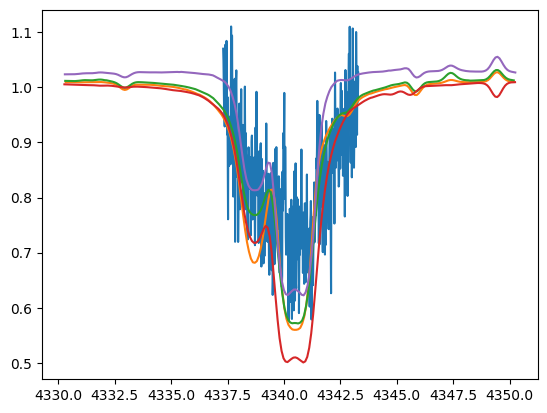

In [7]:
# Normalize line
flux_line_norm = flux_line / p1(wav_line)
plt.plot(wav_line, flux_line_norm)
for model in filtered_models.values():
    wav, flux = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line_wav-delta, line_wav+delta)
    plt.plot(wav,flux)
plt.show()

Perform $\chi^{2}$ fit for all models.

In [8]:
def chi_squared(wav_model, flux_model, wav_line, flux_line, SNR):

    # Get the flux for every wavelenght of the data.
    # Create a CubicSpline object
    cubic_spline = CubicSpline(wav_model, flux_model)

    # Interpolate intensity at the desired wavelengths
    flux_model_inter = cubic_spline(wav_line)

    # Calculate chi-squared
    chi_squared = 0
    for i in range(len(flux_line)):
        chi_squared += ( (flux_model_inter[i] - flux_line[i]) / (1 / SNR) ) ** 2
    chi_squared /= len(wav_line)

    return chi_squared

In [10]:
chi2 = {}
for key, model in models.items():
    # Extract the line from the model
    wav, flux = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line_wav-delta, line_wav+delta)

    # Calculate chi-squared for model
    chi2[key] = chi_squared(wav, flux, wav_line, flux_line_norm, 9)

In [11]:
print(f"The minimum chi-squared: {chi2[min(chi2, key=chi2.get)]}")
print(f"This is for model: {min(chi2, key=chi2.get)}")

The minimum chi-squared: 0.7211039654629444
This is for model: T38000logg3.6


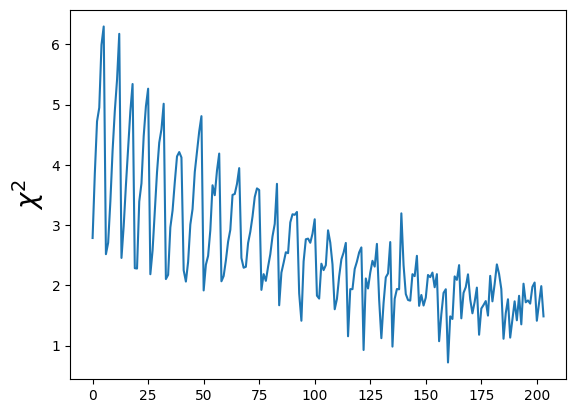

In [12]:
plt.plot(chi2.values())
plt.ylabel(r'$\chi^{2}$', size=20)
plt.show()

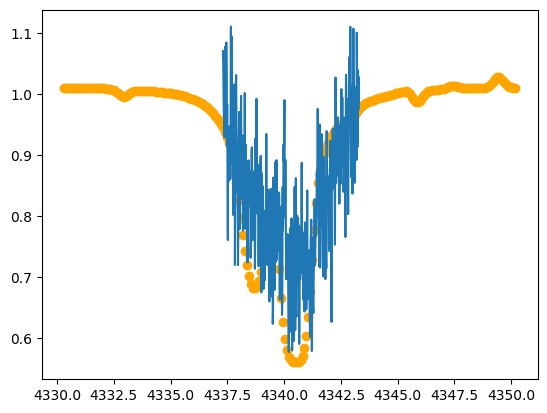

In [13]:
wav, flux = extract_spectrum_within_range(np.array(models['T30000logg3.2']['WAVELENGTH']), np.array(models['T30000logg3.2']['FLUX']), line_wav-delta, line_wav+delta)
plt.scatter(wav, flux, color='orange')
plt.plot(wav_line, flux_line_norm)
plt.show()

Apply dopplerbroadening

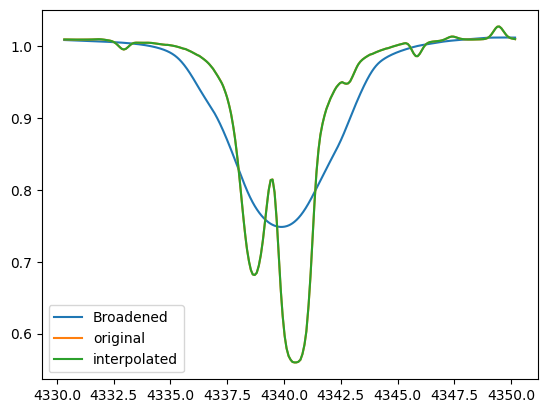

In [14]:
# PyAstronomy requires equal spacings between the wavelength intervals
# PyAstronomy provides a packege for this.
w2, f2 = pyasl.equidistantInterpolation(wav, flux, 0.01)

# Obtain the broadened spectrum using
# vsini = 13.3 km/s and no limb-darkening
rflux = pyasl.rotBroad(w2, f2, 0.0, 200)

plt.plot(w2, rflux, label='Broadened')
plt.plot(wav, flux, label='original')
plt.plot(w2, f2, label='interpolated')
plt.legend()
plt.show()

Calculate $\chi^{2}$ with doppler broadening applied.

In [16]:
chi2 = {}
for key, model in models.items():
    # Extract the line from the model
    wav, flux = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line_wav-delta, line_wav+delta)

    # Apply doppler broadening
    w2, f2 = pyasl.equidistantInterpolation(wav, flux, "2x")

    # Obtain the broadened spectrum using
    rflux = pyasl.rotBroad(w2, f2, 0.0, 180)

    # Calculate chi-squared for model
    chi2[key] = chi_squared(w2, rflux, wav_line, flux_line_norm, 9)

The minimum chi-squared: 0.4834778307644931
This is for model: T26000logg2.8


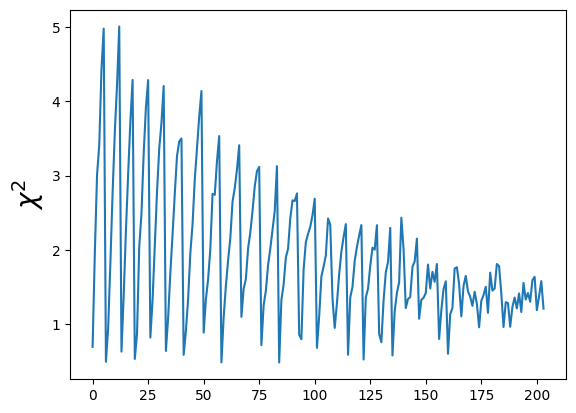

In [17]:
print(f"The minimum chi-squared: {chi2[min(chi2, key=chi2.get)]}")
print(f"This is for model: {min(chi2, key=chi2.get)}")

plt.plot(chi2.values())
plt.ylabel(r'$\chi^{2}$', size=20)
plt.show()

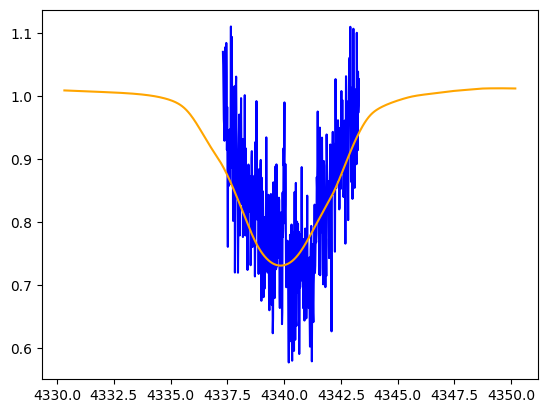

In [18]:
wav, flux = extract_spectrum_within_range(np.array(models['T30000logg3.2']['WAVELENGTH']), np.array(models['T30000logg3.2']['FLUX']), line_wav-delta, line_wav+delta)

# Apply doppler broadening
w2, f2 = pyasl.equidistantInterpolation(wav, flux, "2x")

# Obtain the broadened spectrum using
rflux = pyasl.rotBroad(w2, f2, 0.0, 180)

plt.plot(wav_line, flux_line_norm, color='blue')
plt.plot(w2, rflux, color='orange')
plt.show()

##### Determine the overall doppler shift

In [19]:
# List with the lines that are appropriate to fit a gauss
# lines: [wavelength, name, continuum left, line left, line right, continuum right]
_4U1538_52 = {
    'lines': [
        [4340.46, r"H$\gamma$: 4340.46", 4325, 4335, 4340.7, 4347],
        [4387.93, r"He I: 4387.93", 4381, 4383.75, 4388.20, 4393],
        [4471.50, r"He I: 4471.50", 4459, 4466.2, 4472, 4477.5],
        [4713.17, r"He I: 4713.17", 4703, 4708.5, 4713, 4717],
        [4861.33, r"H$\beta$: 4861.33", 4845, 4854.5, 4862, 4870], 
        [4921.93, r"He I: 4921.93", 4910, 4916, 4922.4, 4932],
        [5015.68, r"He I: 5015.68", 5000, 5010.4, 5016, 5024],
    ],
    'Doppler_guess': 2.8
}

In [20]:
def gaussian(x: list, mean: float, amplitude: float, stddev: float, continuum: float)->list:
    """
    Gauss

    Args:
        x (list): Data
        mean (float): mu
        amplitude (float): amplitude
        stddev (float): sigma
        continuum (float): c parameter

    Returns:
        list: y-values of gauss
    """
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2) + continuum

In [21]:
# Dictionary to save the fit results.
fit_results = {}

# Fit a gauss to all spectral lines
for line in _4U1538_52['lines']:
    # Rest wavelength of the spectral line
    central_wavelength = line[0]

    # Select the spectrum that contains the spectral line
    wav, flux = select_spectrum(spectra, central_wavelength)

    # Extract the spectral line from the spectrum
    wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
    wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
    wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])

    # Initial guess for the parameters
    initial_guess = [line[0] - _4U1538_52['Doppler_guess'], # mu
                     max(flux)/min(flux), # amplitude
                     (max(wav_line) - min(wav_line)) / 4, # stddev
                     np.mean(flux_cont)] # continuum height

    # Fit the data
    params, covariance = curve_fit(gaussian, wav, flux, p0=initial_guess)

    # Save results
    fit_results[line[1]] = {"spectrum": (wav, flux),
                            "continuum": (wav_cont, flux_cont),
                            "line": (wav_line, flux_line),
                            "fit_result": (params, covariance),
                            "rest_wavelength": line[0]}


Determine the doppler shift

In [22]:
# Calculate the dopplershift for every line
doppler_shift = []
for line, data in fit_results.items():
    lambda0 = data['rest_wavelength']
    delta_lambda = data['fit_result'][0][0] - lambda0
    velocity = delta_lambda / lambda0 * 3E5 # km/s
    doppler_shift.append(velocity)

print(doppler_shift)
print(f'The velocity of the object is: {np.mean(doppler_shift)} +- {np.std(doppler_shift)}')

[-167.22721147877763, -145.8445988035299, -177.66977115226172, -166.39814183727918, -185.04045378927998, -159.28411175173233, -162.14430213737472]
The velocity of the object is: -166.2297987071765 +- 11.748720966404955


Plot the fit results

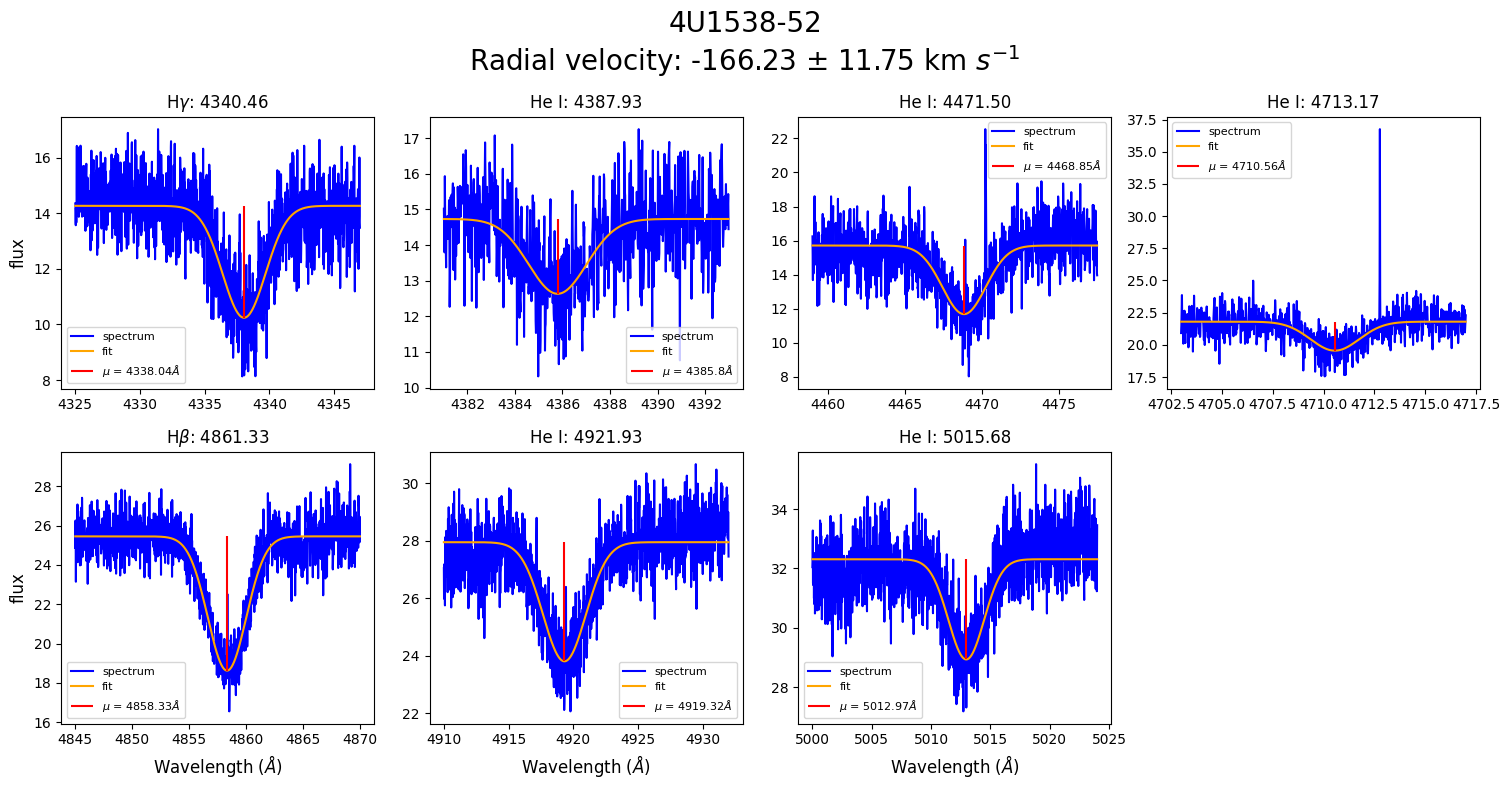

In [23]:
num_plots = len(fit_results)
num_rows = (num_plots - 1) // 4 + 1  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))

# Flatten axes if necessary
if num_rows == 1:
    axes = [axes]

for i, ax_row in enumerate(axes):

    for j, ax in enumerate(ax_row):
        plot_index = i * 4 + j

        if plot_index < num_plots:
            key = list(fit_results.keys())[plot_index]
            wav, flux = fit_results[key]['spectrum']
            fit = gaussian(wav, *fit_results[key]['fit_result'][0])

            ax.plot(wav, flux, color='blue', label='spectrum')  # Plot your data here
            ax.plot(wav, fit, color='orange', label='fit')
            ax.vlines(fit_results[key]['fit_result'][0][0], ymin=min(fit), ymax=max(fit),
                      label=(r'$\mu$ = ' + f"{round(fit_results[key]['fit_result'][0][0], 2)}" + r'$\AA$'), color='red')
            ax.set_title(f'{key}')
            ax.legend(fontsize=8)

        else:
            ax.axis('off')  # Turn off axis for unused subplots
        
        if j == 0:
            ax.set_ylabel('flux', size=12)
        if i == len(axes) - 1:
            ax.set_xlabel(r'Wavelength ($\AA$)', size=12)

plt.suptitle(f"{object_name}\nRadial velocity: {round(np.mean(doppler_shift), 2)}" + r" $\pm$ " + f"{round(np.std(doppler_shift), 2)}" + r" km $s^{-1}$", size=20)
plt.tight_layout()
plt.show()

Calculate $\chi^{2}$ for all lines and all models.

Iteration T56000logg4.2

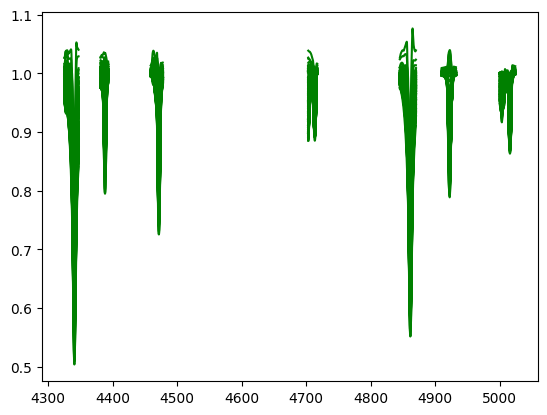

In [24]:
# Signal to noise ratio
SNR = 9

chi2 = {}

for key, model in models.items():
    print(f"\rIteration {key}", end='', flush=True)
    # Chi-squared parameter
    chi2[key] = 0

    for line in _4U1538_52['lines']:
        # Rest wavelength of the spectral line
        central_wavelength = line[0]

        # Select the spectrum that contains the spectral line
        wav, flux = select_spectrum(spectra, central_wavelength)

        # Extract the spectral line from the spectrum
        wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
        wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
        wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])
        # Extract the line from the model
        wav_model, flux_model = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line[2], line[5])

        # Linear fit to continuum
        cont_fit = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))
        # Normalize spectrum
        flux /= cont_fit(wav)
        flux_cont /= cont_fit(wav_cont)
        flux_line /= cont_fit(wav_line)

        # Apply doppler broadening
        wav_model, flux_model = pyasl.equidistantInterpolation(wav_model, flux_model, "2x")
        flux_model = pyasl.rotBroad(wav_model, flux_model, 0.0, 166.2297987071765)

        chi2[key] += chi_squared(wav_model, flux_model, wav_line, flux_line, SNR)

    # Devide the total chi-squared by the number of lines.
    chi2[key] /= len(_4U1538_52['lines'])


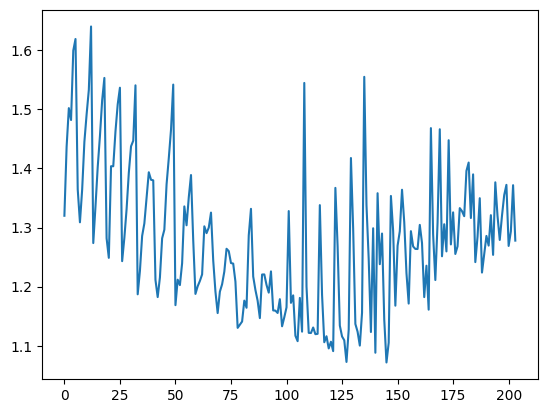

1.071685393421377
The minimum chi-squared: 1.071685393421377
This is for model: T34000logg4.2


In [28]:
plt.plot(chi2.values())
plt.show()

print(f"The minimum chi-squared: {chi2[min(chi2, key=chi2.get)]}")
print(f"This is for model: {min(chi2, key=chi2.get)}")

In [30]:
%matplotlib qt
model = models['T34000logg4.2']
for line in _4U1538_52['lines']:
    # Rest wavelength of the spectral line
    central_wavelength = line[0]

    # Select the spectrum that contains the spectral line
    wav, flux = select_spectrum(spectra, central_wavelength)

    # Extract the spectral line from the spectrum
    wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
    wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
    wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])
    # Extract the line from the model
    wav_model, flux_model = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line[2], line[5])

    # Linear fit to continuum
    cont_fit = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))
    # Normalize spectrum
    flux /= cont_fit(wav)
    flux_cont /= cont_fit(wav_cont)
    flux_line /= cont_fit(wav_line)

    # Apply doppler broadening
    wav_model, flux_model = pyasl.equidistantInterpolation(wav_model, flux_model, "2x")
    flux_model = pyasl.rotBroad(wav_model, flux_model, 0.0, 166.2297987071765)

    plt.plot(wav, flux)
    plt.plot(wav_model, flux_model)
    plt.plot()